<a href="https://colab.research.google.com/github/asanneh/CS109A-Final-Project/blob/master/notebook/FinalProject31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Libraries and Million Playlist Data

In [0]:
#Import the relevant libraries
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import random
import itertools
import copy

Helpful guide to using Google Colab: https://towardsdatascience.com/getting-started-with-google-colab-f2fff97f594c. 

The Million Playlist Data (MPD) in its raw format is made up of CSVs 0 through 999, each with 1000 playlists. Each CSV is 11 MB, so the unzipped size of the data is 11 GB. For processing in a reasonable time frame, code can be run on the GPU (TPU) by going to Runtime > change runtime type > GPU (TPU). That should give more space. 

To get access to the data, first the Google Drive holding the dataset must be mounted. The raw MPD was merged into a single CSV file called 'combined_playlist.csv'. This CSV file has an extra row denoting what CSV file the playlists came from. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')# force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#load entire playlist to dataframe, note there is a performance hit here since I/O can't be parallelized
#You can limit how many rows you read in by including nrows
#songs = pd.read_csv('/content/drive/My Drive/Spotify/combined_playlist_v2.csv') #nrows = 10000000
songs = pd.read_csv('/content/drive/My Drive/Spotify/combined_playlist_v2.csv')
print(f'dataset shape: {songs.shape}')

KeyboardInterrupt: ignored

In [0]:
print(f'unique CSV files: {len(songs.file_name.unique())}')
print(f'number of playlists: {songs.pidfile_name.nunique()}')
print(f'unique songs: {len(songs.track_uri.unique())}')
songs.head()

unique CSV files: 1000
number of playlists: 1000000
unique songs: 2262292


,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,file_name,pidfile_name
0,0,0,Sleeping At Last,spotify:track:2d7LPtieXdIYzf7yHPooWd,spotify:artist:0MeLMJJcouYXCymQSHPn8g,Chasing Cars,spotify:album:0UIIvTTWNB3gRQWFoxoEDh,242564,"Covers, Vol. 2",songs284,0songs284
1,0,1,Rachael Yamagata,spotify:track:0y4TKcc7p2H6P0GJlt01EI,spotify:artist:7w0qj2HiAPIeUcoPogvOZ6,Elephants,spotify:album:6KzK9fDNmj7GHFbcE4gVJD,253701,Elephants...Teeth Sinking Into Heart,songs284,0songs284
2,0,2,The Cinematic Orchestra,spotify:track:6q4c1vPRZREh7nw3wG7Ixz,spotify:artist:32ogthv0BdaSMPml02X9YB,That Home,spotify:album:5cPHT4yMCfETLRYAoBFcOZ,103920,Ma Fleur,songs284,0songs284
3,0,3,The Cinematic Orchestra,spotify:track:54KFQB6N4pn926IUUYZGzK,spotify:artist:32ogthv0BdaSMPml02X9YB,To Build A Home,spotify:album:5cPHT4yMCfETLRYAoBFcOZ,371320,Ma Fleur,songs284,0songs284
4,0,4,Leon Bridges,spotify:track:0NeJjNlprGfZpeX2LQuN6c,spotify:artist:3qnGvpP8Yth1AqSBMqON5x,River,spotify:album:4svLfrPPk2npPVuI4kXPYg,238560,Coming Home,songs284,0songs284


The columns of the MPD are as follows:

1.   **pid:** playlist ID within the original CSV
2.   **pos:** position of song within the playlist
3.   **artist_name:** name of the artist (string)
4.   **track_uri:** unique track Spotify Identifier
5.   **artist_uri:** unique artist Spotify Identifier
6.   **track_name:** name of the track (string)
7.   **album_uri:** unique album Spotify Identifier
8.   **duration_ms:** track duration in ms
9.   **album_name:** name of album
10.  **file_name:** identifier of CSV where playlists came from 
11.  **pidfile_name:** unique playlist identifier

In order to make recommendations for songs for a particular playlist, we will eventually need to create a matrix of playlists by all the unique songs in the MPD. For this, we will need to pick the appropriate song identifier to make sure we are capturing all the unique songs. We will compare **track_name** vs **track_uri** labels to see what is better. 



In [0]:
#what identifier should we use
print(f'unique songs by uri: {len(songs.track_uri.unique())}')
print(f'unique songs by name: {len(songs.track_name.unique())}\n')
#print(f'unique artist+track combos (uri):{len(songs.groupby(["track_uri", "artist_uri"]))}')
#print(f'unique artist+track combos (name):{len(songs.groupby(["track_name", "artist_name"]))}\n')


unique songs by uri: 2262292
unique songs by name: 1483760



We see here that the number of unique songs by **track_uri** is larger than what is given when using **track_name**. This fits well with our understanding that song names can repeated, but that Spotify has unique identifiers for the songs that can disambiguate songs of the same name. Let's take a look at several songs with the same name. 

In [0]:
#drop duplicated songs and count occurences of song names
songs.drop_duplicates(subset = 'track_uri')['track_name'].value_counts()

Intro                                                1559
Silent Night                                          946
Home                                                  843
White Christmas                                       617
O Holy Night                                          554
                                                     ... 
Burro Amarrado                                          1
Appalachian Spring (Original Version): Meno mosso       1
Messa da Requiem: 2. Lacrymosa                          1
The Painters Portrait, Pt. 1                            1
Show Me What You Got (feat. Trina)                      1
Name: track_name, Length: 1483759, dtype: int64

It seems that **track_uris** are a better way to go here - unique to each song and artist, regardless of name overlaps. Especially with cover songs - could be entirely different styles and belong in different playlists. 

# Data Wrangling

Google Colab cannot do EDA on the whole file without running out of RAM on the GPU. To try and ameliorate this and to allow us enough RAM to do model building as well, we are choosing to randomly drop 50% of the playlists from our original file, leaving us with 500K playlists to work with. While we would like to be able to work with the whole dataset, we do not have nearly enough compute power available to us to effectively analyze it. 

In [0]:
random.seed(0)
pid_to_keep = np.random.choice(songs['pidfile_name'].unique(), 500000, replace = False)
drop_idx = songs.loc[songs.pidfile_name.isin(pid_to_keep)].index

In [0]:
songs.drop(drop_idx, inplace = True)

In [0]:
print(f'number of playlists: {songs.pidfile_name.nunique()}')

number of playlists: 500000


In [0]:
#let's drop the unneeded columns pid and file_name and just keep pidfile_name
songs.drop(columns = ['pid', 'file_name'], inplace=True)
songs.shape

(33143261, 9)

In [0]:
songs.to_csv('500k_playlists.csv')

In [0]:
!cp 500k_playlists.csv /content/drive/My\ Drive/CS109A\ project/Spotify

# Data Cleaning

Before we proceed with further data analysis, we should make sure that our data is clean - no missingness, consistent types, etc. 

In [0]:
#Import the relevant libraries
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import random

In [0]:
songs = pd.read_csv('/content/drive/My Drive/Spotify/500k_playlists.csv', index_col=0)
print(f'dataset shape: {songs.shape}')
songs.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


dataset shape: (33143261, 9)


,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,pidfile_name
0,0,Sleeping At Last,spotify:track:2d7LPtieXdIYzf7yHPooWd,spotify:artist:0MeLMJJcouYXCymQSHPn8g,Chasing Cars,spotify:album:0UIIvTTWNB3gRQWFoxoEDh,242564,"Covers, Vol. 2",0songs284
1,1,Rachael Yamagata,spotify:track:0y4TKcc7p2H6P0GJlt01EI,spotify:artist:7w0qj2HiAPIeUcoPogvOZ6,Elephants,spotify:album:6KzK9fDNmj7GHFbcE4gVJD,253701,Elephants...Teeth Sinking Into Heart,0songs284
2,2,The Cinematic Orchestra,spotify:track:6q4c1vPRZREh7nw3wG7Ixz,spotify:artist:32ogthv0BdaSMPml02X9YB,That Home,spotify:album:5cPHT4yMCfETLRYAoBFcOZ,103920,Ma Fleur,0songs284
3,3,The Cinematic Orchestra,spotify:track:54KFQB6N4pn926IUUYZGzK,spotify:artist:32ogthv0BdaSMPml02X9YB,To Build A Home,spotify:album:5cPHT4yMCfETLRYAoBFcOZ,371320,Ma Fleur,0songs284
4,4,Leon Bridges,spotify:track:0NeJjNlprGfZpeX2LQuN6c,spotify:artist:3qnGvpP8Yth1AqSBMqON5x,River,spotify:album:4svLfrPPk2npPVuI4kXPYg,238560,Coming Home,0songs284


In [0]:
#are there any missing values?
songs.isnull().sum()

pos             0
artist_name     8
track_uri       0
artist_uri      0
track_name      1
album_uri       0
duration_ms     0
album_name      4
pidfile_name    0
dtype: int64

In [0]:
#what are the data types?
songs.dtypes

pos              int64
artist_name     object
track_uri       object
artist_uri      object
track_name      object
album_uri       object
duration_ms      int64
album_name      object
pidfile_name    object
dtype: object

In [0]:
#we have some missing values in artist_name, album_name, and track_name
#Let's take a look at them, maybe we can fill them in by hand using the uri info

songs.loc[songs.artist_name.isnull()]

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,pidfile_name
4293081,4,NaN,spotify:track:4eUsRojrbcfPsdUD7qZZo7,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,Brindisi Ver. 1,spotify:album:5iVF4oYu6lVTOQj2iu6b2b,194386,Opera Greatest Hits,591songs246
8820322,128,NaN,spotify:track:14sdk4mdW6KzKfa8tk0hnn,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,Hello,spotify:album:2CnxsT3zuHV2rDSVqpKxde,18706,Anticon Label Sampler 1999 - 2004,885songs286
8820337,143,NaN,spotify:track:0zyLruNSGOBFsYvVKIrhHo,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,Pity Party People Interlude,spotify:album:2CnxsT3zuHV2rDSVqpKxde,19413,Anticon Label Sampler 1999 - 2004,885songs286
32306209,103,NaN,spotify:track:1x4tbfq3ywvTvJVwgVsSHN,spotify:artist:5acHYRoM4lpJIiHZ4Zi3Is,Menace,spotify:album:63T4BKB9CwXzfMuUBE8RWX,232551,Cellar,63songs816
34634330,58,NaN,spotify:track:3uxxOSDWiBqKBnbU2eSAxI,spotify:artist:3fmUow9gSgOouUw2UnUtzg,NaN,spotify:album:0yiPGCcuMDakfqcmvY6Rk1,135427,NaN,434songs744
55711352,80,NaN,spotify:track:0VffYn4XPllw50b5t8eyU9,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,Love Changes Everything - Track by Track,spotify:album:2ozA83nQINAfGWduklekFp,186786,A Musical Affair (Track by Track),895songs107
55711353,81,NaN,spotify:track:6e7I9PmXBHHmNzoHILhY5e,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,The Music of the Night - Track by Track,spotify:album:2ozA83nQINAfGWduklekFp,211080,A Musical Affair (Track by Track),895songs107
61851152,45,NaN,spotify:track:0hxxhWW4v5dFTTzudq6BT8,spotify:artist:5acHYRoM4lpJIiHZ4Zi3Is,Flute Gasp,spotify:album:5Us2V8uDxjNnlAqpS5olMr,236191,Xtreme Tremble,141songs261


By referencing the **track_uri** in Spotify, it seems that 4 tracks in this category are classical music songs where the primary artist (writer) is listed as N/A. Two tracks are from the same indie rap album, where the primary artist is also N/A. In these cases, it seems that this is truly missing information. What is amusing is that the **artist_uri** for these songs actually points to a reggae group called 'N/A'. When you look at their discography, they have a vast number of classical and opera songs attributed to them...

Besides that, there is one artist called 'NA' and one artist called 'null'. 

It doesn't seem that this will interfere with our collaborative filtering recommender system, just maybe make the song credit information a little more confusing. We will not filter these songs out in the mean time, but we will change the **artist_uri** to NaN to reflect this information for the songs with missing info, and update **artist_name** for those artists named 'NA' and 'null'.   

In [0]:
songs.loc[songs.artist_uri == 'spotify:artist:5acHYRoM4lpJIiHZ4Zi3Is', 'artist_name'] = ['NA']*2
songs.loc[songs.artist_uri == 'spotify:artist:3fmUow9gSgOouUw2UnUtzg', 'artist_name'] = ['null']
songs.loc[songs.artist_uri == 'spotify:artist:4oPYazJJ1o4rWBrTw9lm40', 'artist_uri'] = [np.nan]*5


In [0]:
#we have some missing values in artist_name and album_name. 
#Let's take a look at them, maybe we can fill them in by hand using the uri info

songs.loc[songs.album_name.isnull()]

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,pidfile_name
7069563,86,Loop Garou,spotify:track:5waP9OdTo3Wx5s4IfAq8OT,spotify:artist:6ZcNVoWvuMRbhS789e6saA,Darlin' Don't Go (feat. Sarah Summers),spotify:album:4zLXjNbJaNvj8X97GAnr5i,261906,NaN,513songs494
7293324,20,Loop Garou,spotify:track:5waP9OdTo3Wx5s4IfAq8OT,spotify:artist:6ZcNVoWvuMRbhS789e6saA,Darlin' Don't Go (feat. Sarah Summers),spotify:album:4zLXjNbJaNvj8X97GAnr5i,261906,NaN,868songs133
11813676,44,Loop Garou,spotify:track:5waP9OdTo3Wx5s4IfAq8OT,spotify:artist:6ZcNVoWvuMRbhS789e6saA,Darlin' Don't Go (feat. Sarah Summers),spotify:album:4zLXjNbJaNvj8X97GAnr5i,261906,NaN,116songs122
34634330,58,null,spotify:track:3uxxOSDWiBqKBnbU2eSAxI,spotify:artist:3fmUow9gSgOouUw2UnUtzg,NaN,spotify:album:0yiPGCcuMDakfqcmvY6Rk1,135427,NaN,434songs744


Loop Garou annoyingly named his album 'N/A' which got translated to a NaN in the pandas dataframe. Artist named 'null' also has a track and album named 'null' so that's great. Let's fix the labels. 

In [0]:
songs.loc[songs.album_uri == 'spotify:album:4zLXjNbJaNvj8X97GAnr5i', 'album_name'] = ['N/A']*3
songs.loc[songs.album_uri == 'spotify:album:0yiPGCcuMDakfqcmvY6Rk1', 'album_name'] = ['null']

In [0]:
#missing track names?
songs.loc[songs.track_name.isnull()]

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,pidfile_name
34634330,58,null,spotify:track:3uxxOSDWiBqKBnbU2eSAxI,spotify:artist:3fmUow9gSgOouUw2UnUtzg,NaN,spotify:album:0yiPGCcuMDakfqcmvY6Rk1,135427,null,434songs744


Once again, we have our null artist with null album and null song. We will fix that as well as the null song name for the other artist. 

In [0]:
songs.loc[songs.track_uri == 'spotify:track:3uxxOSDWiBqKBnbU2eSAxI', 'track_name'] = ['null']

# Exploratory Data Analysis (EDA)

In [0]:
#playlist statistics grouped by pid & filename
songs.groupby(['pidfile_name']).count()['track_uri'].describe()

count    500000.000000
mean         66.286522
std          53.645746
min           5.000000
25%          26.000000
50%          49.000000
75%          91.000000
max         250.000000
Name: track_uri, dtype: float64

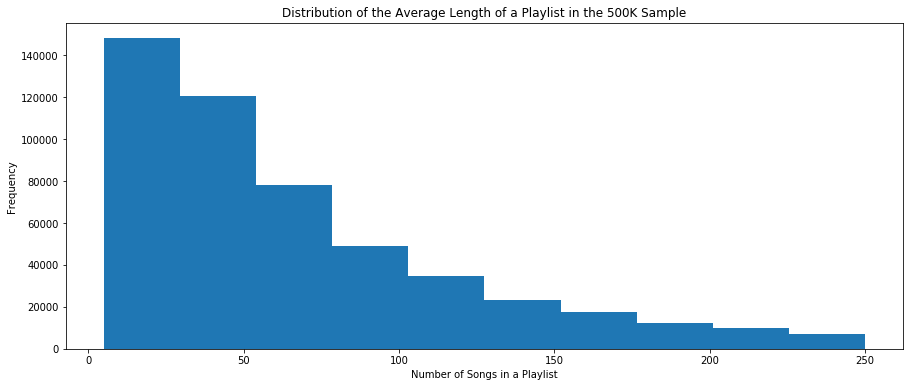

In [0]:
#what is the average length of a playlist - make sure to group by FILE NAME AND PID!!
plt.figure(figsize=(15,6))
ax = songs.groupby(['pidfile_name']).count()['track_uri'].plot(kind = 'hist');
ax.set_xlabel('Number of Songs in a Playlist')
ax.set_title('Distribution of the Average Length of a Playlist in the 500K Sample');

In [0]:
#calculate the duration in minutes
songs['duration_min']=(songs.duration_ms/(1000*60))%60

In [0]:
#stats on song duration
songs.duration_min.describe()

count    3.314326e+07
mean     3.911850e+00
std      1.145048e+00
min      0.000000e+00
25%      3.308433e+00
50%      3.751750e+00
75%      4.322217e+00
max      5.999998e+01
Name: duration_min, dtype: float64

In [0]:
#lets find the index of the longest song
longest_duration = songs.duration_min.nlargest(1)
longest_duration


35639171    59.999983
Name: duration_min, dtype: float64

In [0]:
#what is the longest song based on the index
songs.loc[35639171]

pos                                                            28
artist_name                               Halloween Sound Effects
track_uri                    spotify:track:1ms3hLP7f2mLlSzCuxwv1C
artist_uri                  spotify:artist:0xdm6Qolge99Rs4OAdz0LB
track_name                Smash 3 - Scary Halloween Sound Effects
album_uri                    spotify:album:4yh1SX3FF3zoXd3skJi7a5
duration_ms                                                    -1
album_name      Halloween Shuffle Play - 150 Scary Sounds and ...
pidfile_name                                          591songs563
duration_min                                                   60
Name: 35639171, dtype: object

In [0]:
#categorize songs' durations
songs['duration_cat']=pd.cut(x=songs.duration_min, 
                                 bins=[-.1,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,
                                       11.5,12.5,13.5,14.5,15.5,16.5,17.5,18.5,19.5,20.5,60], 
                                 labels=['0min','1min','2min','3min','4min','5min','6min','7min','8min','9min','10min',
                                         '11min','12min','13min','14min','15min','16min','17min','18min','19min','20min','>20min'])
songs.isnull().sum()

pos             0
artist_name     5
track_uri       0
artist_uri      5
track_name      0
album_uri       0
duration_ms     0
album_name      0
pidfile_name    0
duration_min    0
duration_cat    0
dtype: int64

In [0]:
#Categorical labels for songs'durations
labels_cat=['0min','1min','2min','3min','4min','5min','6min','7min','8min','9min','10min',
        '11min','12min','13min','14min','15min','16min','17min','18min','19min','20min','>20min']
#Calculate the number of each categories
counts=[]
for cat in labels_cat:
  counts.append(songs[songs.duration_cat==cat].count().values[-1])

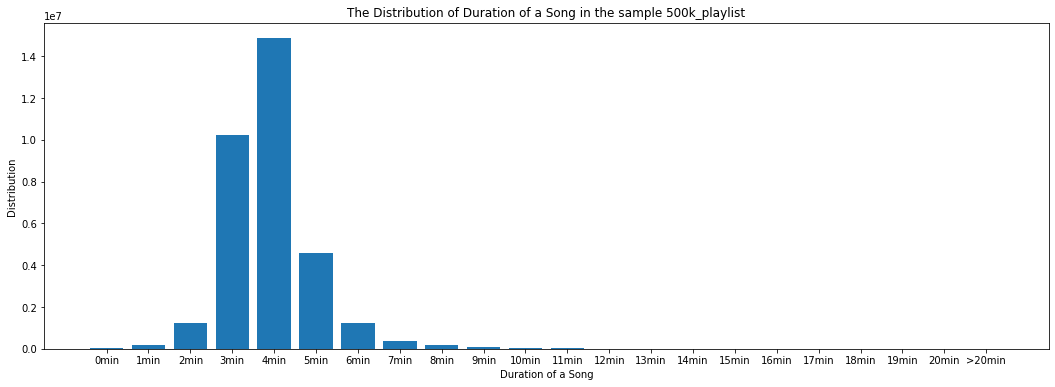

In [0]:
#Plot song duration vs. distribution
plt.figure(figsize=(18,6))
x=np.arange(22)
plt.bar(x,counts)
plt.xticks(x,labels_cat)
plt.xlabel('Duration of a Song')
plt.ylabel('Distribution')
plt.title('The Distribution of Duration of a Song in the sample 500k_playlist')
plt.show()

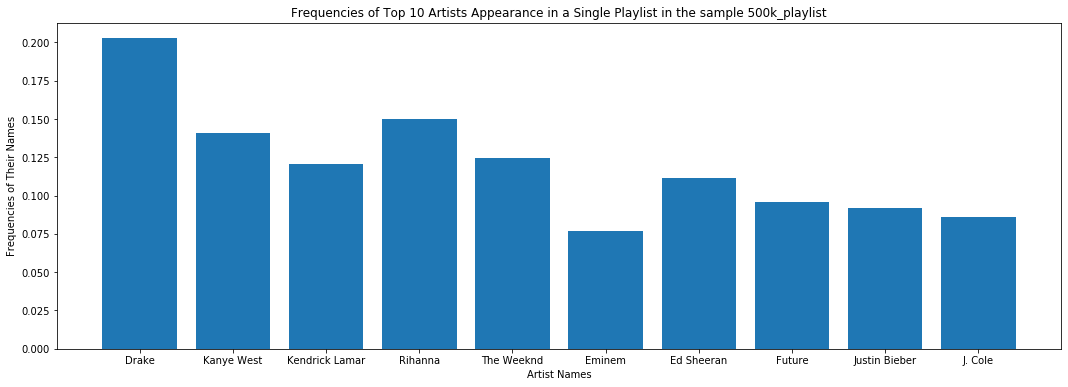

In [0]:
#get the top 10 artists'names 
top10_artists=songs.artist_name.value_counts().index[:10]
#calculate frequencies of their names in a single playlist
freq=[]
for artist in top10_artists:
  freq.append(songs[songs.artist_name==artist].pidfile_name.nunique()/500000)
#plot artists'names vs frequencies
plt.figure(figsize=(18,6))
x=np.arange(10)
plt.bar(x,freq)
plt.xticks(x,top10_artists)
plt.xlabel('Artist Names')
plt.ylabel('Frequencies of Their Names')
plt.title('Frequencies of Top 10 Artists Appearance in a Single Playlist in the sample 500k_playlist')
plt.show()

# Playlist x Unique Songs Sparse Matrix

For further model building, it will be helpful to have a sparse matrix that encodes our playlists in rows and our unique songs in columns. A 1 in a particular cell of the matrix means that playlist has that song. A 0 means it doesn't. We need to carefully look at sparsity here - a matrix that is too sparse means that using matrix factorization to learn latent variables wouldn't work very well because there aren't enough playlist/song interactions. 

references: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/, https://jessesw.com/Rec-System/

In [0]:
#make sparse binary matrix of playlist x uniq song? 0 if song not in playlist, 1 if it is

n_pls = songs.pidfile_name.unique().shape[0]
n_songs = songs.track_uri.unique().shape[0]

#calculate matrix sparsity
print(f'Num playlists: {n_pls}')
print(f'Num unique songs: {n_songs}')
print(f'Sparsity: {100 - float(songs.shape[0]) /float(n_pls*n_songs) * 100:0.3f}%')


Num playlists: 500000
Num unique songs: 1607449
Sparsity: 99.996%


This is very high sparsity! It might be too low for us to make matrix factorization models work. We should try filtering out songs that appear less than N (N is our choice) times across the whole dataset and playlists with too few songs. This might serve to make our matrix more dense. We are aiming for a sparsity of 99.5% and below (https://jessesw.com/Rec-System/)

*N.B. The reason for dropping 'in place' is that the RAM on the Google Collab GPU is insufficient for multiple instances of the whole 11GB dataset. To keep the RAM in check, we can't have two instances of the full or nearly full data.* 

In [0]:
def threshold_data(songs, min_pid_length, min_track_cts):
  '''drops all playlists with length less than min_pid_length and all tracks featured 
  less than min_track_cts in the data. Does so iteratively until data size remains stable.
  Inspired by code from https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/'''

  done = False
  while not done:
    starting_shape = songs.shape[0] #print starting num rows
    #filter playlists
    pid_cts = songs['pidfile_name'].value_counts()
    drop_idx = songs.loc[songs.pidfile_name.isin(pid_cts[pid_cts < min_pid_length].index)].index
    songs.drop(drop_idx, inplace = True)
    #filter songs
    track_cts = songs['track_uri'].value_counts()
    drop_idx = songs.loc[songs.track_uri.isin(track_cts[track_cts < min_track_cts].index)].index
    songs.drop(drop_idx, inplace = True)
    #print ending num rows
    ending_shape = songs.shape[0]
    #break out of while loop if no more rows filtered out
    if starting_shape == ending_shape:
      done = True

  n_pls = songs.pidfile_name.unique().shape[0]
  n_songs = songs.track_uri.unique().shape[0]

  #calculate new matrix sparsity
  print(f'Num playlists: {n_pls}')
  print(f'Num unique songs: {n_songs}')
  print(f'Sparsity: {100 - float(songs.shape[0]) /float(n_pls*n_songs) * 100:0.5f}%')


In [0]:
threshold_data(songs, 50, 50)

Num playlists: 188756
Num unique songs: 48131
Sparsity: 99.79794%


In [0]:
songs.to_csv('dense_playlists.csv')

In [0]:
!cp dense_playlists.csv /content/drive/My\ Drive/CS109A\ project/Spotify

While 99.5% sparsity was the target range recommended by the author of https://jessesw.com/Rec-System/, we expressed hesitation in filtering out too much data to get a dense matrix. We were hesitant that our model would perform well on playlists with few songs, so we decided that a sparsity of 99.8% would be acceptable for further analysis. For reference, Ethan Rosenthal (https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/) used a sparsity of 99.86% with some degree of success. 

# Train-Test Split

We want to be able to assess the performance of our model, but it would be erroneous to drop whole playlists from the dataset, since our collaborative filtering models will eventually need all the playlists (or as many of them as we retained) to learn the latent factors. Therefore, by recommendation of these two websites (https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/, https://jessesw.com/Rec-System/), we will instead use a training set where a certain number of playlist-song interactions are masked from us. 

To do this, we first want to make a sparse matrix that contains a 1 if the playlist has a particular song and a 0 if it doesn't. We will save the full sparse matrix as 'item_user_matrix' and that will be our test set. In this scenario, there will be playlists that have cells with 1+ if they feature the same song multiple times. We have decided to leave these playlists in for our training as these correspond to unique usage patterns. 

To make our train set, we will take the full sparse matrix and mask 10 random cells containg a '1' (or more) for each playlist. For those playlists with less than 50 unique songs, we will not take any songs for the test set if the number of unique songs is less than 20 (max test split is 50%). 

These masked ratings will then be moved to the test set (validation set) sparse matrix. 

In [0]:
#songs = pd.read_csv('/content/drive/My Drive/CS109A project/Spotify/dense_playlists.csv', index_col=0)
print(f'min playlist length: {songs.pidfile_name.value_counts().min()}')
print(f'min track counts: {songs.track_uri.value_counts().min()}')
songs.reset_index(drop=True, inplace=True)

NameError: ignored

In [0]:
#make sparse matrix
cols = songs.pidfile_name.astype('category').cat.codes # make category codes/indices for each playlist
rows = songs.track_uri.astype('category').cat.codes # make category codes/indices for each song
likes = np.ones(songs.shape[0]) #1s if song is in playlist

In [0]:
likes = sparse.csr_matrix((likes, (rows, cols)), dtype=np.float64) #make sparse matrix
print(songs.groupby(by=['pidfile_name', 'track_uri']).count()['track_name'].shape)
likes

(18078662,)


<48131x188756 sparse matrix of type '<class 'numpy.float64'>'
	with 18078662 stored elements in Compressed Sparse Row format>

For later model fitting with the implicit library, we saved the dataset as a sparse row matrix with the items (tracks) as rows and users (playlists) as columns. We can see that we have ~18 million unique interactions between playlist and song. 

In [0]:
sparse.save_npz('item_user_matrix.npz', likes)

In [0]:
!cp item_user_matrix.npz /content/drive/My\ Drive/CS109A\ project/Spotify

In [0]:
#check that the min number of interactions for both songs and playlists is 50
print(f'min num songs in playlist: {likes.sum(axis=1).min()}')
print(f'min num playlists song is featured in: {likes.sum(axis=0).min()}')

min num songs in playlist: 50.0
min num playlists song is featured in: 50.0


In [0]:
#reload data if needed
likes = sparse.load_npz('/content/drive/My Drive/Spotify/item_user_matrix.npz')

In [0]:
#for faster column indexing, change csr to csc
likes = likes.tocsc()

In [0]:
def train_test_split(likes, num_to_mask, rd_seed=random.seed(0)):
  '''
  Make training set with masked interactions

  likes: the full sparse matrix of playlist-song interactions
  num_to_mask: how many interactions we will mask for our training set
  rd_seed: random.seed to use, default 0

  Inspired by: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
  '''
  #make the train and test matrices
  #use lil matrix for efficiency
  train = likes.copy().tolil() #copy all the data to train for later masking
  test = likes.copy().tolil()
  #test = sparse.lil_matrix(likes.shape, dtype=np.float64) #initialize an empty matrix

  for pl in np.arange(0, likes.shape[1]): #for each playlist
    if len(likes.getcol(pl).indices) >= 20: #playlist must have 20+ unique songs
      #mask a random subset of 10 'likes' (1s)
      masked_likes = np.random.choice(likes.getcol(pl).indices, 
                                        size=num_to_mask, 
                                        replace=False)
      train[masked_likes, pl] = 0.

      #mask everything but these likes in the test set
      #scipy has shape assignment mismatch when trying to assign column values
      #from likes matrix to test matrix, even though shapes are equivalent
      cells_to_mask = likes.getcol(pl).indices[~np.isin(likes.getcol(pl).indices, masked_likes)]
      test[cells_to_mask, pl] = 0.

    else: #mask everything from the test set if playlist is under 20 unique songs
      cells_to_mask = likes.getcol(pl).indices
      test[cells_to_mask, pl] = 0.

  return train.tocsc(), test.tocsc()

In [0]:
train_set, val_set = train_test_split(likes, 10)

In [0]:
train_set, val_set

(<48131x188756 sparse matrix of type '<class 'numpy.float64'>'
 	with 16191252 stored elements in Compressed Sparse Column format>,
 <48131x188756 sparse matrix of type '<class 'numpy.float64'>'
 	with 1887410 stored elements in Compressed Sparse Column format>)

In [0]:
likes

<48131x188756 sparse matrix of type '<class 'numpy.float64'>'
	with 18078662 stored elements in Compressed Sparse Column format>

In [0]:
sparse.save_npz('train_set.npz', train_set)
sparse.save_npz('test_set.npz', val_set)

In [0]:
!cp train_set.npz /content/drive/My\ Drive/CS109A\ project/Spotify

In [0]:
!cp test_set.npz /content/drive/My\ Drive/CS109A\ project/Spotify

# Popularity-based Model

I am using the two websites here to figure out how to make a recommender from a sparse matrix:
https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
https://jessesw.com/Rec-System/


A very simple song recommender would recommend the top K (K is up to us) most popular songs in the MPD regardless of the playlist we want song recommendations for. Since we are dealing with implicit ratings (basically, the presence and absence of a song in a playlist), song popularity can be measured by how many times it is featured. Even though there is a risk of duplicate songs within a playlist, these playlists are 1% of our total data, and therefore we will not worry about this caveat now.  

In [0]:
#load train and validation sets
train_set = sparse.load_npz('/content/drive/My Drive/Spotify/train_set.npz')
val_set = sparse.load_npz('/content/drive/My Drive/Spotify/test_set.npz')

In [4]:
#what are the most popular songs in the training set?
#let's get the indices for these songs
songs_cts = np.ravel(train_set.sum(axis=1))
songs_idx = np.arange(0, len(songs_cts))
popular_songs = pd.DataFrame({'idx': songs_idx, 'cts': songs_cts}).sort_values(by=['cts'], ascending=False)
popular_songs.head()

,idx,cts
45284,45284,14985.0
12075,12075,14120.0
48016,48016,13404.0
44411,44411,13042.0
22005,22005,13002.0


A way to measure performance of a recommendation model is to use precision@K (https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54). Precision@K evaluates the proportion of K recommended items that are relevant to the user. In our case, this means what proportion of K recommended songs are 1+ in the train/test matrix. We will choose K of 10 to evaluate both the train and test matrices. 

In [0]:
def precision_at_k(recs, mat, k, pl_index):
  '''
  recs: array of recommended items, sorted in descending order
  
  model: matrix factorization model that has been fit on training set (default=None)
  
  mat: song-playlist matrix (train or test)
  
  k: what k to calculate precision@k for
  
  pl_index: index of playlists to calculate precision@k for

  returns: mean precision@k across all playlists

  Inspired by: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
  '''
  if len(recs.shape)==1: #if there is only one list of recs for all playlists
    top_k_recs = recs[:k] #same recs for all playlists
    precision = []
    for pl in pl_index:
        relevant_songs = mat.getcol(pl).indices
        precision.append(float(len(np.intersect1d(top_k_recs, relevant_songs)))/float(k))
  elif len(recs.shape)==2: #if the recs is an array of playlists by recced songs
    precision = []
    for pl in pl_index:
      top_k_recs = recs[pl, :k] #take recs for a particular playlist
      relevant_songs = mat.getcol(pl).indices
      precision.append(float(len(np.intersect1d(top_k_recs, relevant_songs)))/float(k))
  else:
    print('Recs must be either a 1D or 2D array')

  return np.mean(precision)

In [0]:
#make pl_index - filter out playlists that did not get any values in the test set
def make_pl_index(train_set):
  '''
  returns array of indices of playlists that have interactions in the test set
  '''
  pl_index = []
  for pl in np.arange(0, train_set.shape[1]): #for each playlist
    if len(train_set.getcol(pl).indices) >= 10: #playlist in train_set must have 10+ songs remaining
      pl_index.append(pl)

  return np.array(pl_index)

In [7]:
#make array of popular songs indices
recs = np.array(popular_songs['idx'])
recs.shape

(48131,)

In [8]:
#make pl_index to iterate over
pl_index = make_pl_index(train_set)
pl_index.shape

(188748,)

In [0]:
mean_precision = precision_at_k(recs, train_set, 10, pl_index)
print(f'Average precision@(k=10) for the training set: {mean_precision:0.4f}')

Average precision@(k=10) for the training set: 0.0650


In [0]:
mean_precision = precision_at_k(recs, val_set, 10, pl_index)
print(f'Average precision@(k=10) for the test set: {mean_precision:0.4f}')

Average precision@(k=10) for the test set: 0.0075


Given the top 10 popular songs as our blanket recommendation for all playlists, our precision on the training set is 6.5% and on the test set 0.75%. Not great, but hopefully collaborative filtering will improve this!

# Collaborative Filtering Model

Our goal with collaborative filtering is to use a matrix factorization algorithm to learn the latent features of the playlist-song matrix to be able to give more playlist-specific recommendations.

We will try to implement the Alternating Least Squares Recommender model in the implicit python library. This is a model that does Weighted Regularized Matrix Factorization using Alternating Least Squares to find the proper factorization of a sparse matrix. 

We will try to optimize the following to get the best precision@k:

1. Number of latent features
2. Confidence in the values of the playlist-song matrix - a scaling term that is multiplied by all non-zero values of the matrix
3. Iterations used in optimization
4. Regularization of the latent features

We are using the following sources for reference:

Implicit Rec System Tutorial: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/

Implicit Library Docs: https://implicit.readthedocs.io/en/latest/quickstart.html

In [9]:
#install library
!pip install implicit

     |████████████████████████████████| 1.1MB 2.8MB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3471577 sha256=856a54b19371e424c308b53a2d7df1bc763922dee8372732107b69470af566e8
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [0]:
import implicit

In [0]:
#load validation and train sets
train_set = sparse.load_npz('/content/drive/My Drive/Spotify/train_set.npz')
val_set = sparse.load_npz('/content/drive/My Drive/Spotify/test_set.npz')

In [32]:
#need to multiply train set by alpha factor for confidence matrix to put in model
alpha = 1
conf_train_set = (train_set*alpha).tocsr()
conf_train_set.dtype

dtype('float64')

In [0]:
#initialize model
!export OPENBLAS_NUM_THREADS=1
mf_model = implicit.als.AlternatingLeastSquares(factors=32, iterations=50, calculate_training_loss=True)

In [34]:
#fit model (fast)
mf_model.fit(conf_train_set)

In [0]:
#get recommendations from fit model - training set (slow)
recs_train = mf_model.recommend_all(train_set.T.tocsr(), filter_already_liked_items=False)

In [0]:
#get recommendations from fit model - validation set (slow)
recs_val = mf_model.recommend_all(val_set.T.tocsr(), filter_already_liked_items=False)

In [0]:
print(recs_train.shape,train_set.shape)
print(recs_val.shape, val_set.shape)

(188756, 10) (48131, 188756)
(188756, 10) (48131, 188756)


In [29]:
#make pl_index to iterate over
pl_index = make_pl_index(train_set)
pl_index.shape

(188748,)

In [0]:
#calculate precision@k for training set
mean_precision = precision_at_k(recs_train, train_set, 10, pl_index)
print(f'Average precision@(k=10) for the training set: {mean_precision:0.4f}')

Average precision@(k=10) for the training set: 0.4345


In [0]:
#calculate precision@k for validation set
mean_precision = precision_at_k(recs_val, val_set, 10, pl_index)
print(f'Average precision@(k=10) for the test set: {mean_precision:0.4f}')

Average precision@(k=10) for the test set: 0.0508


Yay! We did it - we improved in our precision@k metric on both training and validation sets from the baseline model performance. Now we should look at whether we can optimize hyperparameters for better performance.

In [0]:
def print_log(row, header=False, spacing=12):
  """
  function to make the results of the printout pretty
  source: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
  """
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, float):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)

In [0]:
def learning_curve(model,train, val, epochs, k=10, pl_index=None):
  '''  
  model: matrix factorization model that has been fit on training set (default=None)
  
  train: song-playlist matrix (train set)

  val: song-playlist matrix (validation set)

  epochs: number of epochs to run
  
  k: what k to calculate precision@k for
  
  pl_index: index of playlists to calculate precision@k for

  returns: model, train_precion, test_precision

  source: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/

  '''
    if not pl_index.all():
        pl_index = range(train.shape[0])
    train_precision = []
    test_precision = []
    
    headers = ['epochs', 'p@k train', 'p@k test']
    print_log(headers, header=True)
    
    for epoch in epochs:
        model.fit(train)
        recs_train=model.recommend_all(train.T.tocsr(), filter_already_liked_items=False)
        recs_val=model.recommend_all(val.T.tocsr(), filter_already_liked_items=False)
        train_precision.append(precision_at_k(recs_train, train, k, pl_index))
        test_precision.append(precision_at_k(recs_val, val, k, pl_index))
        row = [epoch, train_precision[-1], test_precision[-1]]
        print_log(row)
    return model, train_precision, test_precision

In [0]:
def grid_search_learning_curve(base_model, train, test, param_grid,
                               pl_index=None, patk=10, epochs=range(2, 40, 2)):
  """
  model: matrix factorization model that has been fit on training set (default=None)
  
  train: song-playlist matrix (train set)

  val: song-playlist matrix (validation set)

  param_grid: Dictionary of hyperparameters to tune

  epochs: number of epochs to run
  
  k: what k to calculate precision@k for
  
  pl_index: index of playlists to calculate precision@k for

  returns: curves, train_patk, test_patk

  source: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
  """
    curves = []
    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        this_model = copy.deepcopy(base_model)
        print_line = []
        for k, v in params.items():
            setattr(this_model, k, v)
            print_line.append((k, v))

        print(' | '.join('{}: {}'.format(k, v) for (k, v) in print_line))
        _, train_patk, test_patk= learning_curve(this_model, train, test,
                                                                epochs, k=patk, pl_index=pl_index)
        curves.append({'params': params,
                       'patk': {'train': train_patk, 'test': test_patk}})
                       
    return curves, train_patk, test_patk

In [0]:
#initialize hyper parameters
param_grid = {'num_factors': [32, 64],  
              'regularization': [1e-1,1e-2, 1e1],
              'alpha': [1, 10, 50]}

In [77]:
#initialize the base model
!export OPENBLAS_NUM_THREADS=1
base_model = implicit.als.AlternatingLeastSquares(iterations=50, calculate_training_loss=True )


In [0]:
#perform grid search
curves,train_precision, test_precision = grid_search_learning_curve(base_model, train_set, val_set,
                                    param_grid,
                                    pl_index=pl_index,
                                    epochs=range(2,12,2),
                                    patk=10)


num_factors: 32 | regularization: 0.1 | alpha: 1
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+



|     2      |  0.60853   |  0.04594   |
+------------+------------+------------+



|     4      |  0.60809   |  0.04604   |
+------------+------------+------------+



|     6      |  0.60789   |  0.04601   |
+------------+------------+------------+



|     8      |  0.60779   |  0.04599   |
+------------+------------+------------+



|     10     |  0.60779   |  0.04599   |
+------------+------------+------------+
num_factors: 32 | regularization: 0.1 | alpha: 10
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+



|     2      |  0.60852   |  0.04595   |
+------------+------------+------------+



|     4      |  0.60829   |  0.04582   |
+------------+------------+------------+



|     6      |  0.60806   |  0.04592   |
+------------+------------+------------+



|     8      |  0.60780   |  0.04599   |
+------------+------------+------------+



|     10     |  0.60770   |  0.04600   |
+------------+------------+------------+
num_factors: 32 | regularization: 0.1 | alpha: 50
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+



|     2      |  0.60857   |  0.04592   |
+------------+------------+------------+



|     4      |  0.60796   |  0.04596   |
+------------+------------+------------+



|     6      |  0.60803   |  0.04595   |
+------------+------------+------------+



|     8      |  0.60800   |  0.04592   |
+------------+------------+------------+



|     10     |  0.60792   |  0.04598   |
+------------+------------+------------+
num_factors: 32 | regularization: 0.01 | alpha: 1
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+



|     2      |  0.60923   |  0.04587   |
+------------+------------+------------+



|     4      |  0.60866   |  0.04580   |
+------------+------------+------------+



|     6      |  0.60827   |  0.04585   |
+------------+------------+------------+



|     8      |  0.60800   |  0.04593   |
+------------+------------+------------+



|     10     |  0.60773   |  0.04601   |
+------------+------------+------------+
num_factors: 32 | regularization: 0.01 | alpha: 10
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+



|     2      |  0.60836   |  0.04598   |
+------------+------------+------------+



|     4      |  0.60804   |  0.04595   |
+------------+------------+------------+



|     6      |  0.60789   |  0.04596   |
+------------+------------+------------+



|     8      |  0.60790   |  0.04596   |
+------------+------------+------------+



|     10     |  0.60784   |  0.04600   |
+------------+------------+------------+
num_factors: 32 | regularization: 0.01 | alpha: 50
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+



|     2      |  0.60838   |  0.04598   |
+------------+------------+------------+



|     4      |  0.60798   |  0.04607   |
+------------+------------+------------+



|     6      |  0.60786   |  0.04597   |
+------------+------------+------------+



|     8      |  0.60778   |  0.04596   |
+------------+------------+------------+



|     10     |  0.60771   |  0.04598   |
+------------+------------+------------+
num_factors: 32 | regularization: 10.0 | alpha: 1
+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  |
+============+============+============+



|     2      |  0.60623   |  0.04605   |
+------------+------------+------------+



|     4      |  0.60558   |  0.04611   |
+------------+------------+------------+



|     6      |  0.60543   |  0.04613   |
+------------+------------+------------+


Buffered data was truncated after reaching the output size limit.

In [0]:
#save the variables return by grid search function as numpy matrix
sparse.save_npz('curves.npz', curves)
sparse.save_npz('test_precision.npz', test_precision)
sparse.save_npz('train_precision.npz', train_precision)

In [0]:
# store the return variables in google drive
!cp curves.npz /content/drive/My\ Drive/Spotify
!cp train_precision.npz /content/drive/My\ Drive/Spotify
!cp test_precision.npz /content/drive/My\ Drive/Spotify



In [0]:

#load all data
item_user_set = sparse.load_npz('/content/drive/My Drive/Spotify/item_user_matrix.npz')


In [0]:
#need to multiply dense matrix by best model alpha factor for confidence matrix
alpha = 1
conf_item_user_set = (item_user_set*alpha).tocsr()

In [0]:
#initialize model with best model hyperparameters
!export OPENBLAS_NUM_THREADS=1
best_model = implicit.als.AlternatingLeastSquares(factors=32, iterations=50, regularization=10.0, calculate_training_loss=True)

In [53]:
#fit all data on best model
best_model.fit(conf_item_user_set)

In [54]:
#get recommendations of all data fit on best model
recs_item_user = best_model.recommend_all(item_user_set.T.tocsr(), filter_already_liked_items=False)

In [0]:
#make playlist index from all data dense matrix to iterate through
pl_index_item_user = make_pl_index(item_user_set)

In [58]:
#calculate precision@k for all data
mean_precision_best_model = precision_at_k(recs_item_user, item_user_set, 10, pl_index_item_user)
print(f'Average precision@(k=10) for best model: {mean_precision_best_model:0.4f}')

Average precision@(k=10) for best model: 0.4055


In [36]:
#get recommendation from base model using all data dense matrix
recs_item_user_with_train = mf_model.recommend_all(item_user_set.T.tocsr(), filter_already_liked_items=False)

In [60]:
#calculate precision@k using recommendation from base model on all data dense matrix
mean_precision_item_user_train = precision_at_k(recs_item_user_with_train, item_user_set, 10, pl_index_item_user)
print(f'Average precision@(k=10) for dense matrix fit on train: {mean_precision_item_user_train:0.4f}')

Average precision@(k=10) for dense matrix fit on train: 0.4062


# Performance of Best Model

Now we have our final model! We should evaluate our performance on data we held out - this includes short playlists that we removed to make a less sparse matrix, as well as playlists from the other 500k that were filtered out at the very start. 

We will have to make an item-user matrix for the held out data (no thresholding to make less sparse this time around) and have our best model do recommendations for the playlists. Performance will be measured in terms of precision@k, where k can go lower than 10, if we choose to include short playlists (less than 10 songs)

In [39]:
#make sparse matrix from playlists that were too short (filtered out at thresholding step)
songs = pd.read_csv('/content/drive/My Drive/Spotify/dense_playlists_filtout.csv', index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
#make sparse matrix
cols = songs.pidfile_name.astype('category').cat.codes # make category codes/indices for each playlist
rows = songs.track_uri.astype('category').cat.codes # make category codes/indices for each song
likes = np.ones(songs.shape[0]) #1s if song is in playlist

In [41]:
filtout_likes = sparse.csr_matrix((likes, (rows, cols)), dtype=np.float64) #make sparse matrix
print(songs.groupby(by=['pidfile_name', 'track_uri']).count()['track_name'].shape)
filtout_likes

(11329153,)


<1379610x311244 sparse matrix of type '<class 'numpy.float64'>'
	with 11329153 stored elements in Compressed Sparse Row format>

In [0]:
#save sparese matrix
sparse.save_npz('item_user_matrix_filtout.npz', filtout_likes)

In [0]:
#store sparse matrix in google drive
!cp item_user_matrix_filtout.npz /content/drive/My\ Drive/Spotify

In [0]:
#load sparse matrix
filtout_likes = sparse.load_npz('/content/drive/My Drive/Spotify/item_user_matrix_filtout.npz')

In [63]:
#make playlist index to iterate through of sparse matrix
pl_index_filtout = make_pl_index(filtout_likes)

KeyboardInterrupt: ignored

In [62]:
#get recommendations from fit model - short playlist set (slow)
recs_filtout = best_model.recommend_all(filtout_likes.T.tocsr(), filter_already_liked_items=False)

#calculate precision@k for short playlist set
mean_precision = precision_at_k(recs_filtout, filtout_likes, 10, pl_index_filtout)
print(f'Average precision@(k=10) for the short playlist set: {mean_precision:0.4f}')

ValueError: ignored

In [0]:
#make sparse matrix from subset of 500k playlists that were held out at the start

In [0]:
#evaluate precision@k

Now let's look at some example recommendations - let's take the recommended songs for some random playlists and see how the recommended songs compare to what is already in the playlist. 

Since it is difficult to objectively evaluate 'appropriateness' of recommended songs, we can do our best quantitative measure by looking at the audio features of songs already in the playlist and comparing them with audio features of recommended songs. Since a lot of the Spotify audio features are continuous (https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/), we can try to use PCA for visualization. 

In [0]:
#example recommendations

In [0]:
#PCA